## Setup

In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

import tensorflow as tf    
from tensorflow import keras
from tensorflow.keras import layers


from keras.preprocessing import sequence
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)


print(tf.__version__)

2.2.0


## Load the titanic dataset
You will use the Titanic dataset with the (rather morbid) goal of predicting passenger survival, given characteristics such as gender, age, class, etc.

In [2]:
# Load dataset.
df = pd.read_csv('PovidersUnique.csv')
df.head()

,PID,Fraud,DeductibleAmt,AmtReimbursed,CountOfCID,AvgAmtReimb,AvgAmtDed,CountOfBene,AvgReimbPerBene,AvgDedPerBene,AvgAge
0,PRV51001,No,5340,104640,25,4186,214,24,4360,223,79
1,PRV51003,Yes,66286,605670,132,4588,502,117,5177,567,70
2,PRV51004,No,310,52170,149,350,2,138,378,2,72
3,PRV51005,Yes,3700,280910,1165,241,3,495,567,7,70
4,PRV51007,No,3264,33710,72,468,45,58,581,56,69


## Explore the data

The dataset contains the following features

In [3]:
df.dtypes

PID                object
Fraud              object
DeductibleAmt       int64
AmtReimbursed       int64
CountOfCID          int64
AvgAmtReimb         int64
AvgAmtDed           int64
CountOfBene         int64
AvgReimbPerBene     int64
AvgDedPerBene       int64
AvgAge              int64
dtype: object

There are approximately twice as many male passengers as female passengers aboard.

The majority of passengers were in the "third" class.

### Base Feature Columns

In [4]:
df['Fraud']=df['Fraud'].apply(lambda x: 1 if x=='Yes' else 0)
df.head()

,PID,Fraud,DeductibleAmt,AmtReimbursed,CountOfCID,AvgAmtReimb,AvgAmtDed,CountOfBene,AvgReimbPerBene,AvgDedPerBene,AvgAge
0,PRV51001,0,5340,104640,25,4186,214,24,4360,223,79
1,PRV51003,1,66286,605670,132,4588,502,117,5177,567,70
2,PRV51004,0,310,52170,149,350,2,138,378,2,72
3,PRV51005,1,3700,280910,1165,241,3,495,567,7,70
4,PRV51007,0,3264,33710,72,468,45,58,581,56,69


In [5]:
df.columns

Index(['PID', 'Fraud', 'DeductibleAmt', 'AmtReimbursed', 'CountOfCID',
       'AvgAmtReimb', 'AvgAmtDed', 'CountOfBene', 'AvgReimbPerBene',
       'AvgDedPerBene', 'AvgAge'],
      dtype='object')

In [6]:
X =df[['DeductibleAmt', 'AmtReimbursed', 'CountOfCID',
       'AvgAmtReimb', 'AvgAmtDed', 'CountOfBene', 'AvgReimbPerBene',
       'AvgDedPerBene','AvgAge']].astype('float32')
y = np.asarray(df['Fraud'])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
dft = scaler.transform(X)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dft, y, test_size=0.10, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (4869, 9) (4869,)
Test set: (541, 9) (541,)


# Class Weight

In [9]:
neg, pos = np.bincount(df['Fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Examples:
    Total: 5410
    Positive: 506 (9.35% of total)

Weight for class 0: 0.55
Weight for class 1: 5.35


# Metrics 

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [11]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


In [12]:
def plot_cm(labels, predictions, p=0.5):
    
      cm = confusion_matrix(labels, predictions > p)
      plt.figure(figsize=(5,5))
      sns.heatmap(cm, annot=True, fmt="d")
      plt.title('Confusion matrix @{:.2f}'.format(p))
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label')

      print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
      print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
      print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
      print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
      print('Total Fraudulent Transactions: ', np.sum(cm[1]))


In [13]:
def plot_loss(history, label, n):
    
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


In [14]:
def plot_roc(name, labels, predictions, **kwargs):
    
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


# RNN Model

In [15]:
seq = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[X.shape[1]]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])


seq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),#defualt 0.001
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)



In [211]:
seq_history=seq.fit( x_train, y_train, epochs=100, validation_data=[x_test,y_test], class_weight=class_weight)


Train on 4869 samples, validate on 541 samples
Epoch 1/100
4869/4869 [==============================] - 11s 2ms/sample - loss: 0.6721 - tp: 119.0000 - fp: 211.0000 - tn: 4200.0000 - fn: 339.0000 - accuracy: 0.8870 - precision: 0.3606 - recall: 0.2598 - auc: 0.7702 - val_loss: 0.6088 - val_tp: 30.0000 - val_fp: 48.0000 - val_tn: 445.0000 - val_fn: 18.0000 - val_accuracy: 0.8780 - val_precision: 0.3846 - val_recall: 0.6250 - val_auc: 0.8982
Epoch 2/100
4869/4869 [==============================] - 1s 268us/sample - loss: 0.6158 - tp: 309.0000 - fp: 616.0000 - tn: 3795.0000 - fn: 149.0000 - accuracy: 0.8429 - precision: 0.3341 - recall: 0.6747 - auc: 0.8682 - val_loss: 0.5818 - val_tp: 39.0000 - val_fp: 76.0000 - val_tn: 417.0000 - val_fn: 9.0000 - val_accuracy: 0.8429 - val_precision: 0.3391 - val_recall: 0.8125 - val_auc: 0.8962
Epoch 3/100
4869/4869 [==============================] - 1s 222us/sample - loss: 0.6039 - tp: 348.0000 - fp: 748.0000 - tn: 3663.0000 - fn: 110.0000 - accuracy: 

4869/4869 [==============================] - 1s 210us/sample - loss: 0.5710 - tp: 386.0000 - fp: 540.0000 - tn: 3871.0000 - fn: 72.0000 - accuracy: 0.8743 - precision: 0.4168 - recall: 0.8428 - auc: 0.9103 - val_loss: 0.5475 - val_tp: 46.0000 - val_fp: 62.0000 - val_tn: 431.0000 - val_fn: 2.0000 - val_accuracy: 0.8817 - val_precision: 0.4259 - val_recall: 0.9583 - val_auc: 0.9400
Epoch 42/100
4869/4869 [==============================] - 1s 214us/sample - loss: 0.5687 - tp: 383.0000 - fp: 477.0000 - tn: 3934.0000 - fn: 75.0000 - accuracy: 0.8866 - precision: 0.4453 - recall: 0.8362 - auc: 0.9081 - val_loss: 0.5512 - val_tp: 44.0000 - val_fp: 60.0000 - val_tn: 433.0000 - val_fn: 4.0000 - val_accuracy: 0.8817 - val_precision: 0.4231 - val_recall: 0.9167 - val_auc: 0.9310
Epoch 43/100
4869/4869 [==============================] - ETA: 0s - loss: 0.5701 - tp: 372.0000 - fp: 517.0000 - tn: 3745.0000 - fn: 70.0000 - accuracy: 0.8752 - precision: 0.4184 - recall: 0.8416 - auc: 0.912 - 1s 229us/

Epoch 82/100
4869/4869 [==============================] - 1s 284us/sample - loss: 0.5677 - tp: 384.0000 - fp: 459.0000 - tn: 3952.0000 - fn: 74.0000 - accuracy: 0.8905 - precision: 0.4555 - recall: 0.8384 - auc: 0.8969 - val_loss: 0.5506 - val_tp: 40.0000 - val_fp: 41.0000 - val_tn: 452.0000 - val_fn: 8.0000 - val_accuracy: 0.9094 - val_precision: 0.4938 - val_recall: 0.8333 - val_auc: 0.9174
Epoch 83/100
4869/4869 [==============================] - 2s 329us/sample - loss: 0.5696 - tp: 381.0000 - fp: 502.0000 - tn: 3909.0000 - fn: 77.0000 - accuracy: 0.8811 - precision: 0.4315 - recall: 0.8319 - auc: 0.9031 - val_loss: 0.5523 - val_tp: 44.0000 - val_fp: 66.0000 - val_tn: 427.0000 - val_fn: 4.0000 - val_accuracy: 0.8706 - val_precision: 0.4000 - val_recall: 0.9167 - val_auc: 0.9327
Epoch 84/100
4869/4869 [==============================] - 1s 221us/sample - loss: 0.5683 - tp: 383.0000 - fp: 478.0000 - tn: 3933.0000 - fn: 75.0000 - accuracy: 0.8864 - precision: 0.4448 - recall: 0.8362 - a

In [20]:
prob = seq.predict(x_test)

yhat = np.round(prob)

In [24]:
plot_loss(seq_history, "RNN Model", 0)

NameError: name 'seq_history' is not defined

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       493
           1       0.23      0.17      0.19        48

    accuracy                           0.88       541
   macro avg       0.57      0.56      0.56       541
weighted avg       0.86      0.88      0.87       541



In [25]:
Rnn_results = seq.evaluate(x_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, Rnn_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, yhat)

NameError: name 'model' is not defined

# CNN Model

In [27]:
X_train3d = np.asarray(x_train).reshape(-1,1,x_train.shape[1])
y_train3d = np.asarray(y_train).reshape(y_train.shape[0],1)
X_test3d = np.asarray(x_test).reshape(-1,1,x_test.shape[1])
y_test3d = np.asarray(y_test).reshape(y_test.shape[0],1)

In [28]:
X_train3d.shape

(4869, 1, 9)

In [31]:
input_shape=(1,9)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=1,
                      strides=1 , padding='same',
                      activation= 'relu', 
                      input_shape=input_shape),
  
  tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation= 'relu'),  
  tf.keras.layers.Dropout(rate=.20),
  tf.keras.layers.MaxPool1D(pool_size=1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation= 'relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')])

#tf.keras.layers.GlobalAveragePooling2D()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),#defualt 0.001
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= METRICS)


In [32]:
cnn_history = model.fit(X_train3d,y_train,epochs=100, validation_data=[X_test3d,y_test],
                    class_weight=class_weight, callbacks = [early_stopping])

Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 0.6557 - tp: 254.0000 - fp: 635.0000 - tn: 3776.0000 - fn: 204.0000 - accuracy: 0.8277 - precision: 0.2857 - recall: 0.5546 - auc: 0.7965

ValueError: in user code:

    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:909 test_step  **
        y_pred = self(x, training=False)
    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/aar/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:155 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer sequential_2 expects 1 inputs, but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 9) dtype=float32>, <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>]


In [33]:
cnn_Pred = model.predict(X_test3d)
yhat_cnn = np.round(cnn_Pred)

In [34]:
plot_loss(cnn_history, "cnn_model", 0)

NameError: name 'cnn_history' is not defined

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       493
           1       0.23      0.17      0.19        48

    accuracy                           0.88       541
   macro avg       0.57      0.56      0.56       541
weighted avg       0.86      0.88      0.87       541



loss :  0.7204794080552684
tp :  41.0
fp :  43.0
tn :  450.0
fn :  7.0
accuracy :  0.9075786
precision :  0.48809522
recall :  0.8541667
auc :  0.9521638

Legitimate Transactions Detected (True Negatives):  450
Legitimate Transactions Incorrectly Detected (False Positives):  43
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  41
Total Fraudulent Transactions:  48


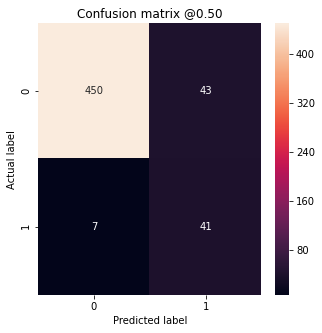

In [225]:
cnn_results = model.evaluate(X_test3d, y_test, verbose=0)
for name, value in zip(model.metrics_names, cnn_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, yhat_cnn)

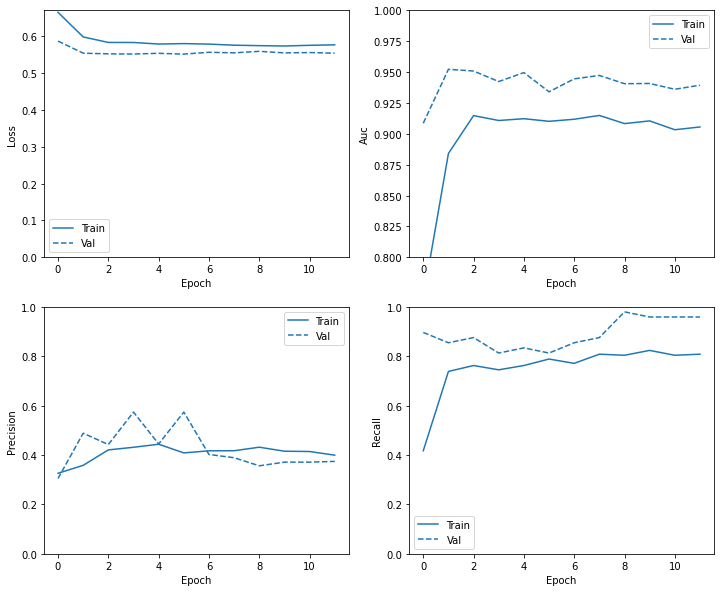

In [226]:
plot_metrics(cnn_history)

# Tensorflow on Imbalanced data

In [229]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train3d.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [230]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [231]:
model = make_model()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 16)                160       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 17        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [234]:
weighted_model = make_model()
#weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    # The class weights go here
    class_weight=class_weight) 


Train on 4869 samples, validate on 541 samples
Epoch 1/100
4869/4869 [==============================] - 9s 2ms/sample - loss: 0.6941 - tp: 446.0000 - fp: 4338.0000 - tn: 73.0000 - fn: 12.0000 - accuracy: 0.1066 - precision: 0.0932 - recall: 0.9738 - auc: 0.6602 - val_loss: 0.6391 - val_tp: 48.0000 - val_fp: 493.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0887 - val_precision: 0.0887 - val_recall: 1.0000 - val_auc: 0.8655
Epoch 2/100
4869/4869 [==============================] - 1s 250us/sample - loss: 0.6407 - tp: 410.0000 - fp: 3009.0000 - tn: 1402.0000 - fn: 48.0000 - accuracy: 0.3722 - precision: 0.1199 - recall: 0.8952 - auc: 0.7633 - val_loss: 0.5886 - val_tp: 47.0000 - val_fp: 149.0000 - val_tn: 344.0000 - val_fn: 1.0000 - val_accuracy: 0.7227 - val_precision: 0.2398 - val_recall: 0.9792 - val_auc: 0.8880
Epoch 3/100
4869/4869 [==============================] - 1s 257us/sample - loss: 0.6080 - tp: 374.0000 - fp: 1787.0000 - tn: 2624.0000 - fn: 84.0000 - accura

Epoch 22/100
4869/4869 [==============================] - 1s 246us/sample - loss: 0.4079 - tp: 370.0000 - fp: 643.0000 - tn: 3768.0000 - fn: 88.0000 - accuracy: 0.8499 - precision: 0.3653 - recall: 0.8079 - auc: 0.9041 - val_loss: 0.3054 - val_tp: 44.0000 - val_fp: 62.0000 - val_tn: 431.0000 - val_fn: 4.0000 - val_accuracy: 0.8780 - val_precision: 0.4151 - val_recall: 0.9167 - val_auc: 0.9546
Epoch 23/100
4869/4869 [==============================] - 1s 239us/sample - loss: 0.3949 - tp: 372.0000 - fp: 634.0000 - tn: 3777.0000 - fn: 86.0000 - accuracy: 0.8521 - precision: 0.3698 - recall: 0.8122 - auc: 0.9107 - val_loss: 0.3019 - val_tp: 44.0000 - val_fp: 67.0000 - val_tn: 426.0000 - val_fn: 4.0000 - val_accuracy: 0.8688 - val_precision: 0.3964 - val_recall: 0.9167 - val_auc: 0.9538
Epoch 24/100
4869/4869 [==============================] - 1s 297us/sample - loss: 0.4106 - tp: 367.0000 - fp: 632.0000 - tn: 3779.0000 - fn: 91.0000 - accuracy: 0.8515 - precision: 0.3674 - recall: 0.8013 - a

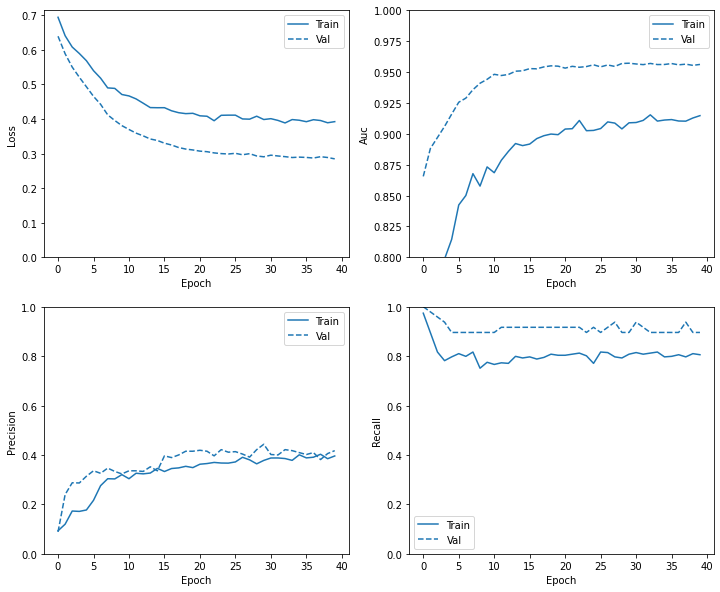

In [239]:
plot_metrics(weighted_history)

In [240]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)


loss :  0.33245697650583306
tp :  43.0
fp :  54.0
tn :  439.0
fn :  5.0
accuracy :  0.8909427
precision :  0.44329897
recall :  0.8958333
auc :  0.95708656

Legitimate Transactions Detected (True Negatives):  439
Legitimate Transactions Incorrectly Detected (False Positives):  54
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  43
Total Fraudulent Transactions:  48


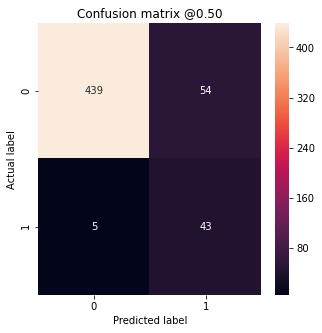

In [242]:
weighted_results = weighted_model.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
      print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)


In [243]:
def plot_loss(history, label, n):
    
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


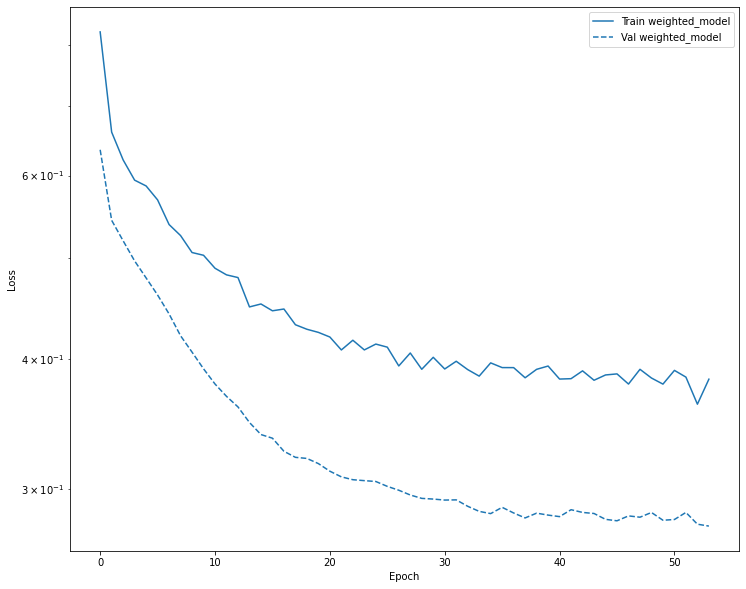

In [105]:
plot_loss(weighted_history, "weighted_model", 0)

In [244]:
def plot_roc(name, labels, predictions, **kwargs):
    
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


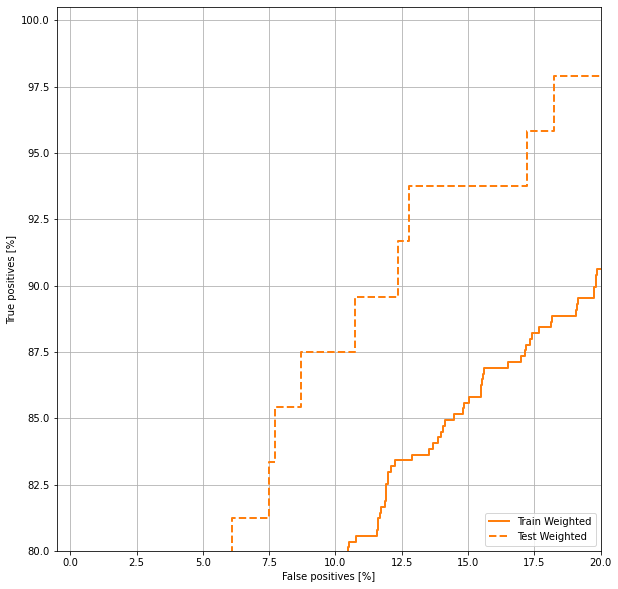

In [245]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')
